In [1]:
# import xesmf as xe
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
from matplotlib.colors import LogNorm
import xroms
import numpy as np
import seawater as sw
from dask.diagnostics import ProgressBar
import scipy.integrate as integ


import sys
sys.path.append("/homes/metogra/iufarias/Documents/Scripts/useful")
import romspickle as rp

from dask.diagnostics import ProgressBar
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})


plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

/homes/metogra/iufarias/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")
/homes/metogra/iufarias/miniconda3/envs/XROMS/lib/python3.8/site-packages/pyproj/__init__.py:90: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
# client=dask.distributed.Client()
# client

In [5]:

def calc_MLD(dens_int,fillna=2e20,thresh=0.125,coo='z_rho'):
    '''
    dens_int: Interpolated density xarray (from xroms.isoslice)
    '''
    if coo in dens_int.dims:            
        dens_int_new=dens_int.dropna(coo)
        zdic={'{0}'.format(coo):0}
        mld_dens = dens_int_new.isel(zdic)  + thresh
        
        z_indexes = (abs(dens_int_new - mld_dens)).fillna(fillna).argmin(coo)
        mld_f = dens_int_new[coo][z_indexes]
    else:
        print('z_rho dimension not found')
    
    return mld_f

In [6]:
# chunks={'time_counter':10, 'x_rho':1000, 'y_rho':1520,'s_rho':40,'s_w':40}

#3D
path='/data/pacific/lrenault/SASI/CROCO/'

# path='/data/pacific/lrenault/SASI/CROCO/'
# listF=glob(path+'FULL/SASI*2012*.nc');listF.sort()
# listT=glob(path+'SMTH/SASI*2012*.nc');listT.sort()

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal')
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal')



In [7]:
gc.collect()

15

In [8]:
# zcollectlevs(h=varf.h.to_numpy(),zeta=varf.zeta[0].to_numpy(),
#          theta_s=np.int(varf.theta_s),theta_b=np.int(varf.theta_b),
#          hc=np.int(varf.hc),N=80)

# zt=rp.zlevs(h=varf.h.to_numpy(),zeta=varf.zeta[0].to_numpy(),
#          theta_s=np.int(varf.theta_s),theta_b=np.int(varf.theta_b),
#          hc=np.int(varf.hc),N=80) 

In [9]:
# varf=varf.assign_coords(z_rho=(('s_rho','y_rho','x_rho'),zf))
# vart=vart.assign_coords(z_rho=(('s_rho','y_rho','x_rho'),zt))

In [10]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=2)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=2)

## Mixed Layer Depth

##### Loading in Temperature and Salinity

In [26]:
with ProgressBar():
    tf=df.temp[::200,:-20,300:-300,90:700].compute()
    sf=df.salt[::200,:-20,300:-300,90:700].compute()
    
    # tf=df.temp[::50,-20:,300:-300,90:700].compute()
    # sf=df.salt[::50,-20:,300:-300,90:700].compute()
    # tf=df.temp[::4*15,-20:,300:-300,90:700].mean(axis=0).compute()
    # sf=df.salt[::4*15,-20:,300:-300,90:700].mean(axis=0).compute()

[##################################      ] | 86% Completed | 79.55 ss


MemoryError: Unable to allocate 109. GiB for an array with shape (120, 1520, 1000, 80) and data type float64

In [ ]:
with ProgressBar():
    # tt=dt.temp[400,:,300:-300,90:700].compute()
    # st=dt.salt[400,:,300:-300,90:700].compute()
    
    tt=dt.temp[::30,-20:,300:-300,90:700].compute()
    st=dt.salt[::30,-20:,300:-300,90:700].compute()    
    # tt=dt.temp[::2*15,-20:,300:-300,90:700].mean(axis=0).compute()
    # st=dt.salt[::2*15,-20:,300:-300,90:700].mean(axis=0).compute()

##### Computing Potential Density

In [12]:
with ProgressBar():
    # sig0=xroms.potential_density(tf,sf)
    rhof=xroms.potential_density(tf,sf)
    rhot=xroms.potential_density(tt,st)


In [37]:
# zdic={'{0}'.format('z_rho0'):0}
mld_dens = dens_int_new.isel(zdic) - 0.125
# dens_int_new - mld_dens
# dens_int_new[0,0,500,500]
# mld_dens[0,500,500]


<xarray.DataArray 'sig0' ()>
array(1025.56503999)
Coordinates:
    nav_lat_rho   float32 36.99
    nav_lon_rho   float32 -124.0
    time_instant  datetime64[ns] 2012-01-01T06:00:00
    ocean_time    datetime64[ns] 2012-01-01T06:00:00
    xi_rho        int64 590
    eta_rho       int64 800
    z_rho0        float64 -2.247
    z_rho         float64 -2.486
Attributes:
    long_name:           potential density
    units:               kg/m^3
    online_operation:    instant
    interval_operation:  6 h
    interval_write:      6 h
    cell_methods:        time: point
    grid:                <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n...
    name:                sig0

##### Interpolating in Z for calculating MLD

In [14]:
sig_f_int=xroms.isoslice(rhof, np.linspace(0,-200, 90),iso_array=rhof.z_rho0)
sig_t_int=xroms.isoslice(rhot, np.linspace(0,-200, 90),iso_array=rhot.z_rho0)

In [38]:

mld_int_f=calc_MLD(sig_f_int,thresh=0.125,coo='z_rho0')
mld_int_t=calc_MLD(sig_t_int,thresh=0.125,coo='z_rho0')

##### Plotting MLD (density)

In [55]:
sig_f_int.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 35)>
array(['2012-01-01T06:00:00.000000000', '2012-01-06T12:00:00.000000000',
       '2012-01-11T18:00:00.000000000', '2012-01-17T00:00:00.000000000',
       '2012-01-22T06:00:00.000000000', '2012-01-27T12:00:00.000000000',
       '2012-02-01T18:00:00.000000000', '2012-02-07T00:00:00.000000000',
       '2012-02-12T06:00:00.000000000', '2012-02-17T12:00:00.000000000',
       '2012-02-22T18:00:00.000000000', '2012-02-28T00:00:00.000000000',
       '2012-03-04T06:00:00.000000000', '2012-03-09T12:00:00.000000000',
       '2012-03-14T18:00:00.000000000', '2012-03-20T00:00:00.000000000',
       '2012-03-25T06:00:00.000000000', '2012-03-30T12:00:00.000000000',
       '2012-04-04T18:00:00.000000000', '2012-04-10T00:00:00.000000000',
       '2012-04-15T06:00:00.000000000', '2012-04-20T12:00:00.000000000',
       '2012-04-25T18:00:00.000000000', '2012-05-01T00:00:00.000000000',
       '2012-05-06T06:00:00.000000000', '2012-05-11T12:00:00.000000000',
       '2012-05-16T18:00:00.000000000', '2012-05-22T00:00:00.000000000',
       '2012-05-27T06:00:00.000000000', '2012-06-01T12:00:00.000000000',
       '2012-06-06T18:00:00.000000000', '2012-06-12T00:00:00.000000000',
       '2012-06-17T06:00:00.000000000', '2012-06-22T12:00:00.000000000',
       '2012-06-27T18:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    time_instant  (ocean_time) datetime64[ns] 2012-01-01T06:00:00 ... 2012-06...
  * ocean_time    (ocean_time) datetime64[ns] 2012-01-01T06:00:00 ... 2012-06...
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1979-01-01 00:00:00
    bounds:         time_counter_bounds

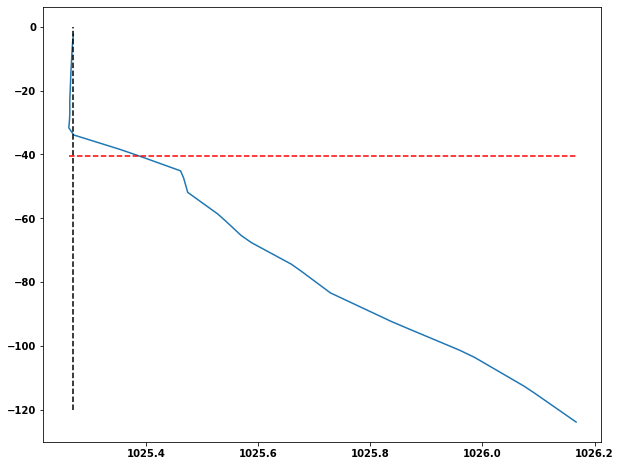

In [58]:
ye=200
xe=300
de=20
plt.figure(figsize=(10,8))
plt.plot(sig_f_int[de,:,ye,xe],sig_f_int[de,:,ye,xe].z_rho)
plt.plot([sig_f_int[de,1,ye,xe],sig_f_int[de,1,ye,xe]],[-120,0],'k--')
plt.plot([sig_f_int[de,:,ye,xe].min(),sig_f_int[de,:,ye,xe].max()],[mld_int_f[de,ye,xe],mld_int_f[de,ye,xe]],'r--')

In [60]:
mlddiff=mld_int_f-mld_int_t
mldmean=0.5*(mld_int_f + mld_int_t)
mld_ult=mld_int_f.mean(axis=1).mean(axis=1) -mld_int_t.mean(axis=1).mean(axis=1)


norm=(mlddiff/mldmean)*100
norm2=(mlddiff.mean(axis=1).mean(axis=1)/mldmean.mean(axis=1).mean(axis=1))*100
norm_ult=mld_ult/()


In [23]:
for id in range(tf.shape[0]):
    plt.figure(figsize=(16,8))

    lvls=np.arange(-60,0,10)

    plt.subplot(2,3,1)
    mld_int_f[id].plot(x='nav_lon_rho',y='nav_lat_rho',
                                 cmap='rainbow',levels=np.linspace(-60,0,55),
                                 cbar_kwargs={'ticks': lvls,'label':'$m$ '})

    plt.title(r'MLD (FULL)',fontsize=13,fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Lat')

    plt.subplot(2,3,2)

    mld_int_t[id].plot(x='nav_lon_rho',y='nav_lat_rho',
                                 cmap='rainbow',levels=np.linspace(-60,0,55),
                                 cbar_kwargs={'ticks': lvls,'label':'$m$ '})
    plt.title(r'MLD (SMTH)',fontsize=13,fontweight='bold')

    plt.xlabel('')
    plt.ylabel('')


    plt.subplot(2,3,3)



    norm[id].plot(x='nav_lon_rho',y='nav_lat_rho',
                                 cmap='seismic',levels=np.linspace(-100,100,55),
              cbar_kwargs={'ticks':np.arange(-100,120,20),'label':r'$\%$'})
    plt.title(r'MLD (Difference)',fontsize=13,fontweight='bold')

    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

    plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/timeseries/MLD_difference_{0}.png'.format(pd.DatetimeIndex(tf.ocean_time)[id]))
    plt.close()

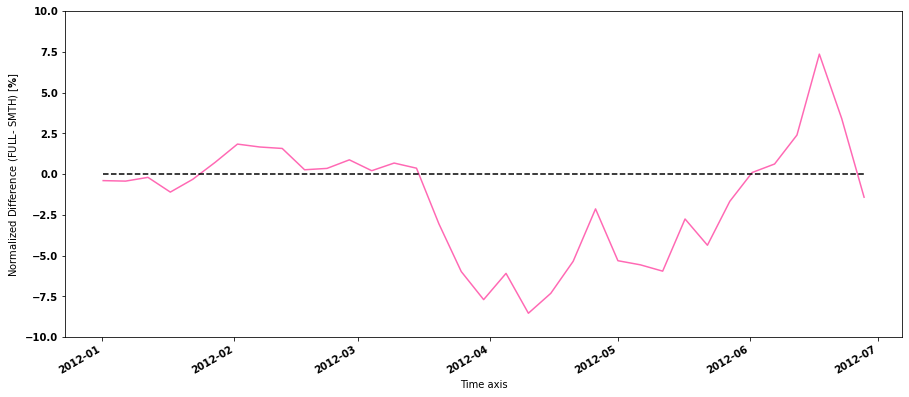

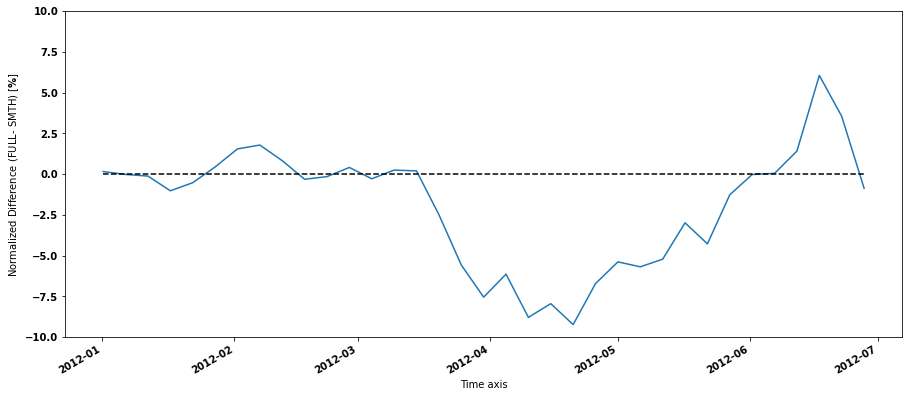

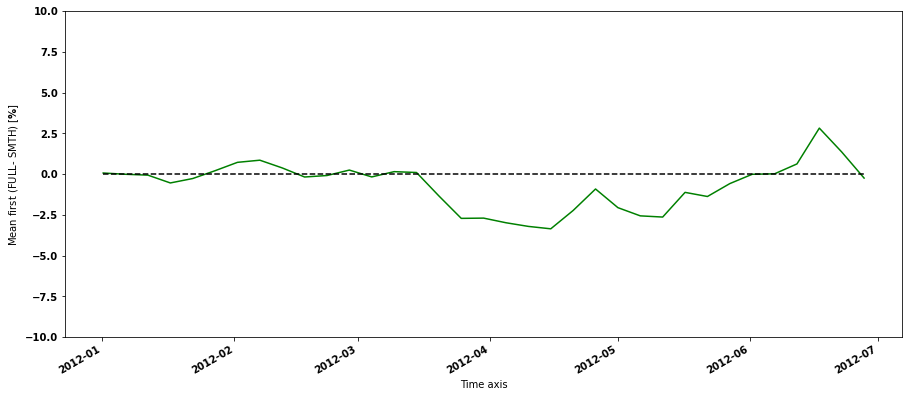

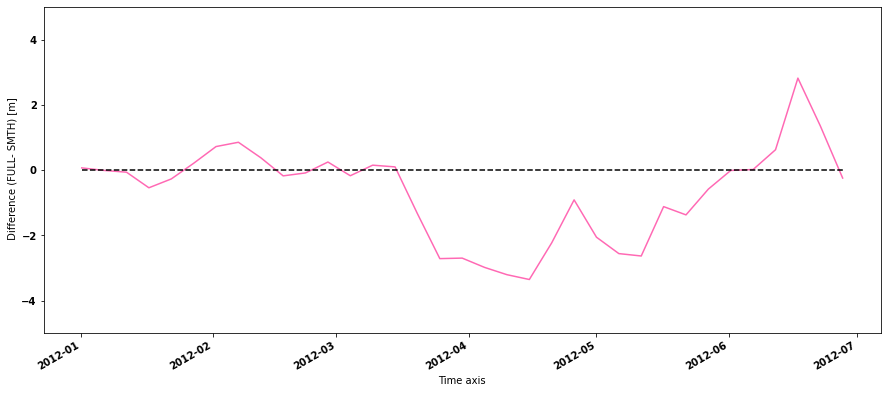

In [62]:
plt.figure(figsize=(15,6))
norm.mean(axis=1).mean(axis=1).plot(color='hotpink')
plt.plot(norm.ocean_time,np.zeros(norm.ocean_time.shape),'k--')

plt.ylim(-10,10)
plt.ylabel(r'Normalized Difference (FULL- SMTH) [$\%$]')

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/MLD_fluctuation_normdiff_4days.png')

plt.figure(figsize=(15,6))
norm2.plot()
plt.plot(norm.ocean_time,np.zeros(norm.ocean_time.shape),'k--')
plt.ylim(-10,10)
plt.ylabel(r'Normalized Difference (FULL- SMTH) [$\%$]')



plt.figure(figsize=(15,6))
(mld_ult*-1).plot(color='green')
plt.plot(norm.ocean_time,np.zeros(norm.ocean_time.shape),'k--')
plt.ylim(-10,10)
plt.ylabel(r'Mean first (FULL- SMTH)')


plt.figure(figsize=(15,6))
(mlddiff*-1).mean(axis=1).mean(axis=1).plot(color='hotpink')
plt.plot(norm.ocean_time,np.zeros(norm.ocean_time.shape),'k--')

plt.ylim(-5,5)
plt.ylabel(r' Difference (FULL- SMTH) [m]')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/MLD_fluctuation_diff_4days.png')


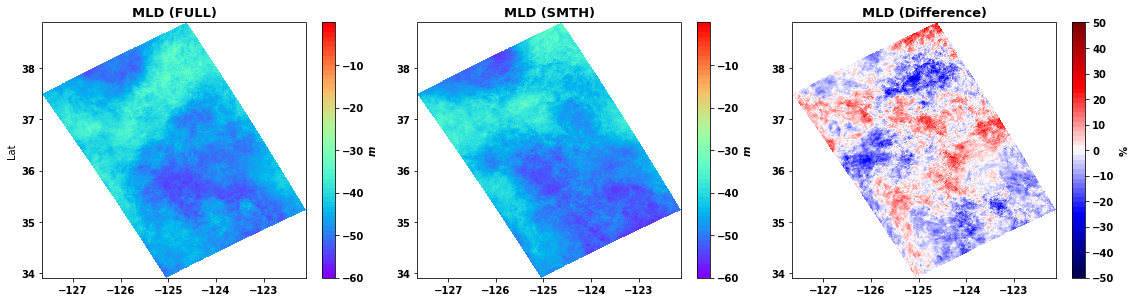

In [27]:
plt.figure(figsize=(16,8))

lvls=np.arange(-60,0,10)

plt.subplot(2,3,1)
mld_int_f.mean(axis=0).plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='rainbow',levels=np.linspace(-60,0,55),
                             cbar_kwargs={'ticks': lvls,'label':'$m$ '})

plt.title(r'MLD (FULL)',fontsize=13,fontweight='bold')
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,3,2)

mld_int_t.mean(axis=0).plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='rainbow',levels=np.linspace(-60,0,55),
                             cbar_kwargs={'ticks': lvls,'label':'$m$ '})
plt.title(r'MLD (SMTH)',fontsize=13,fontweight='bold')

plt.xlabel('')
plt.ylabel('')


plt.subplot(2,3,3)



norm.mean(axis=0).plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='seismic',levels=np.linspace(-50,50,55),
          cbar_kwargs={'ticks':np.arange(-50,60,10),'label':r'$\%$'})
plt.title(r'MLD (Difference)',fontsize=13,fontweight='bold')

plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/MLD_diffs_4days.png')

##### Plotting MLD (Temperature)

In [202]:

# T_int=xroms.isoslice(tf,iso_values=np.linspace(0,-300, 90),axis='Z')
# mld2=calc_MLD(T_int,thresh=+0.5)

# plt.figure(figsize=(10,8))
# plt.contourf(mld2,levels=np.linspace(-100,-3,55),cmap='rainbow',extend='both')

# plt.colorbar()

# Parameterization

In [74]:
import seawater as sw

In [75]:
sw.alpha

Signature: sw.alpha(s, t, p, pt=False)
Docstring:
Calculate the thermal expansion coefficient.

Parameters
----------
s(p) : array_like
       salinity [psu (PSS-78)]
t(p) : array_like
       temperature or potential temperature [℃ (ITS-90)]
p : array_like
    pressure [db].
pt : bool
     True if temperature is potential, default is False

Returns
-------
alpha : array_like
        thermal expansion coeff :math:`\alpha` [℃ :sup:`-1`]

Examples
--------
>>> # Data from McDougall 1987
>>> import seawater as sw
>>> s, t, p = 40, 10, 4000
>>> sw.alpha(s, t, p, pt=True)
0.00025061316481624323

References
----------
.. [1] McDougall, Trevor J., 1987: Neutral Surfaces. J. Phys. Oceanogr.,
   17, 1950-1964. doi: 10.1175/1520-0485(1987)017<1950:NS>2.0.CO;2
File:      ~/miniconda3/envs/XROMS/lib/python3.8/site-packages/seawater/eos80.py
Type:      function


In [11]:
bfi=xr.open_dataarray("/homes/metogra/iufarias/Documents/data/bfi.nc")



In [41]:
bfi.shape

(18, 10, 1119, 650)

In [96]:
N2=(np.gradient(bfi,axis=1)/-10).mean(axis=0).mean(axis=1).mean(axis=1)[0]
# np.sqrt(N2)
N2

1.5216197100279557e-05

In [104]:
a_c=30
rho_o=1025
f2=(1e-4)**2
L2=(10e3)**2
H2=100**2
rho_a=1.25
C_d=1.2e-3
U_a=10
C_p=4000


In [105]:
R=(-2/3)*((a_c*rho_o*f2*L2)/(rho_a*C_d*U_a*C_p*N2*H2))
R

-2245.414306971546

In [17]:
(5.2e-3)**2

2.704e-05